In [1]:
#access kaggle dataset 
!pip install kaggle
#machine learning
!pip install catboost
#eli5
!pip install eli5

     |████████████████████████████████| 62.5MB 1.2MB/s 
     |████████████████████████████████| 112kB 3.3MB/s 


In [0]:
#imports
import sys
import scipy
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import os
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#file access 
from google.colab import files

#upload file
uploaded = files.upload()

#print 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# #json file from kaggle 
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [4]:
#download data from kaggle 
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 29.4MB/s]
 98% 237M/242M [00:04<00:00, 50.6MB/s]
100% 242M/242M [00:04<00:00, 60.7MB/s]
100% 2.02G/2.03G [00:36<00:00, 41.3MB/s]
100% 2.03G/2.03G [00:36<00:00, 59.2MB/s]


In [5]:
#unzip training data 
!ls
!unzip train.csv.zip
!ls

sample_data  sample_submission.csv  test.zip  train.csv.zip
Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
#extract train data into a df for manip
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [7]:
#take a look at the 1st 10 
train.head(20)

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788
5,8,1.4690999777
6,9,1.4690999766
7,7,1.4690999755
8,-5,1.4690999744
9,3,1.4690999733


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 57.2 MB


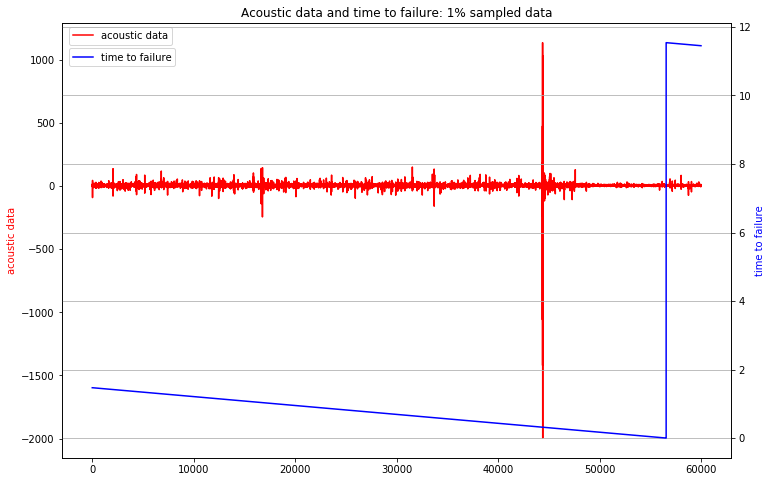

In [9]:
#visualize 1% (first 100) 
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#plotting function
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3451526e10>,
      dtype=object)

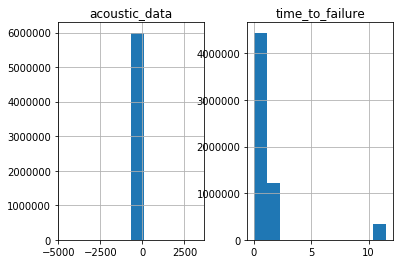

In [10]:
#basic histogram
train.hist()

In [0]:
#Feature eng. -- function to generate stat features from train data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [18]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000,4195.000000000000000
mean,4.519475157932917,6.547788190832376,-149.190941597139442,163.522288438617409,68.297997078886311,0.125830201533653,-11.224603098927293,-2.184779499404052,11.231716328963049,20.321890345649656,170.046245530393321,5.547366504438947,5.750164895071956
std,0.256049485926947,8.503939490256958,265.087983547740237,272.930331447498872,70.532565012634521,0.477901196543982,14.106851749718865,2.346558457187657,2.358067486415371,14.225526173874824,296.887014915214138,1.517037556246679,8.339211436139040
min,3.596313333333333,2.802720142449153,-5515.000000000000000,23.000000000000000,0.648601727651454,-4.091826220725587,-336.000000000000000,-39.000000000000000,9.000000000000000,11.000000000000000,23.000000000000000,4.147706666666667,2.589085218316308
25%,4.349496666666667,4.478637142151063,-154.000000000000000,92.000000000000000,28.090227382235867,-0.040779004942732,-14.000000000000000,-3.000000000000000,10.000000000000000,15.000000000000000,94.000000000000000,5.061843333333334,3.862810034013982
50%,4.522146666666667,5.618797774899163,-111.000000000000000,123.000000000000000,45.816624913747923,0.085619830683749,-10.000000000000000,-2.000000000000000,11.000000000000000,19.000000000000000,127.000000000000000,5.380853333333333,4.781513433258028
75%,4.693350000000001,6.880903553140399,-79.000000000000000,170.000000000000000,78.664201990993135,0.253930302215080,-6.000000000000000,-1.000000000000000,12.000000000000000,23.000000000000000,175.000000000000000,5.748553333333334,5.887947257796146
max,5.391993333333334,153.703569356093254,-15.000000000000000,5444.000000000000000,631.158926834507270,4.219428824355885,-2.000000000000000,0.000000000000000,50.000000000000000,337.000000000000000,5515.000000000000000,32.762073333333333,150.432368254177703


In [20]:
y_train.describe()

count    4195.000000000000000
mean        5.683670382745305
std         3.673246302936231
min         0.006397657167800
25%         2.635348205000000
50%         5.358795935000000
75%         8.177499732950000
max        16.103195567000000
dtype: float64

In [21]:
#Model #1 - Catboost

train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.47441934696739}}

In [22]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [23]:
#Kernel Ridge
from sklearn.kernel_ridge import KernelRidge

parameters = [{'gamma': np.linspace(0.001, 0.1, 10),
               'alpha': [0.005, 0.01, 0.02, 0.05, 0.1]}]

reg2 = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv=5, scoring='neg_mean_absolute_error')
reg2.fit(X_train_scaled, y_train.values.flatten())
y_pred2 = reg2.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg2.best_score_))
print(reg2.best_params_)

Best CV score: -2.2046
{'alpha': 0.1, 'gamma': 0.012}
